# LangGraph 구조설계 | LangGraph 그래프 로직 flow 설계
## 기본그래프 생성

LangGraph의 그래프를 정의하기 위해서는 
1. State 정의
2. Node 정의
3. Edge 정의
4. Graph compile
5. Graph visualize

단계를 거치게 된다.

그래프 생성시 조건부 엣지를 사용하는 방법과 다양한 흐럼 변경을 해보도록 하자.


In [2]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

# State 정의
class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add] # operator.add : list일때만 사용가능
    answer : Annotated[List[Document], operator.add]
    question : Annotated[str, "user question"]
    sql_query : Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]

## Node 정의

In [15]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve:검색
    documents = "검색된 문서"
    return {"context" : documents}

def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform : 질문 변형
    documents = "검색된 문서"
    return GraphState(context=documents)

def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM실행
    answer = "GPT가 생성한 답변"
    return GraphState(answer=answer)

def llm_claude_execute(state: GraphState) -> GraphState:
    # LLM실행
    answer = "Claude가 생성한 답변"
    return GraphState(answer=answer)

def relevance_check(state: GraphState) -> GraphState:
    # Relevance Check: 관련성 확인
    binary_score = "Relevance score"
    return GraphState(binary_score=binary_score)

def sum_up(state: GraphState) -> GraphState:
    # sum_up : 결과 종합
    answer = "종합된 답변"
    return GraphState(answer=answer)

def search_on_web(state: GraphState) -> GraphState:
    # Search On Web : 웹 검색
    documents = state["context"] = "기존문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)

def get_table_info(state: GraphState) -> GraphState:
    # Get Table Info : 테이블 정보 조회
    table_info = "테이블 정보"
    return GraphState(context=table_info)

def generate_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query : SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)

def execute_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query : SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)

def validate_sql_query(state: GraphState) -> GraphState:
    # Validate SQL Query : SQL 쿼리 유효성 검사
    binary_score = "SQL 쿼리 유효성 검사 결과"
    return GraphState(binary_score=binary_score)

def handle_error(state: GraphState) -> GraphState:
    # Handle Error : 오류 처리
    error="에러발생"
    return GraphState(context=error)

def decision(state: GraphState) -> GraphState:
    # Decision : 의사 결정
    decision = "결정"
    # 로직을 추가할 수 있음
    if state["binary_score"] == "yes":
        return "exit"
    else:
        return "retry"

## 그래프 정의

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
# Conventional RAG, 재검색, multi LLM 처리, 쿼리 재작성

# LangGraph.graph에ㅐ서 State와 END를 가져옴.
workflow = StateGraph(GraphState)

# 노드추가
# 검색, 질문 변형, GPT 요청, Claude 요청, 관련성 확인, 종합
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite_query", rewrite_query)

workflow.add_node("request_gpt", llm_gpt_execute)
workflow.add_node("request_claude", llm_claude_execute)

workflow.add_node("gpt_relevance_check", relevance_check)
workflow.add_node("claude_relevance_check", relevance_check)

workflow.add_node("result", sum_up)



workflow.add_edge("retrieve", "request_gpt")
workflow.add_edge("retrieve", "request_claude")

workflow.add_edge("rewrite_query", "retrieve")

workflow.add_edge("request_gpt", "gpt_relevance_check")
workflow.add_edge("gpt_relevance_check", "result")

workflow.add_edge("request_claude", "claude_relevance_check")
workflow.add_edge("claude_relevance_check", "result")


workflow.add_edge("result", END)


# # 조건부 엣지 추가 : 결과 
# workflow.add_conditional_edges(
#     "result",
#     decision,
#     {
#         "재검색": "retrieve",
#         "종료": END
#     }
# )
# 조건부 엣지 추가 : 쿼리 재생성 후 검색
workflow.add_conditional_edges(
    "result",
    decision,
    {
        "재검색": "rewrite_query",
        "종료": END
    }
)

workflow.set_entry_point("retrieve")

# 기록을 위해 메모리 저장소 설정
memory = MemorySaver()

# 그래프 컴파일
flow = workflow.compile(checkpointer=memory)


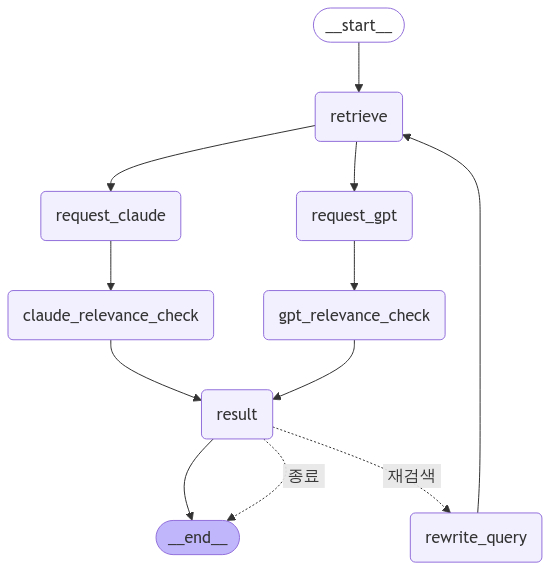

In [14]:
# 그래프 시각화 
img = Image(flow.get_graph(xray=True).draw_mermaid_png())

with open("graph_structure.png", "wb") as f:
    f.write(img.data)

display(Image("graph_structure.png"))

In [16]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(GraphState)

# 노드를 추가합니다.
workflow.add_node("질문", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)

workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)

workflow.add_node("결과 종합", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# 각 노드들을 연결합니다.
workflow.add_edge("질문", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",
    decision,
    {
        "QUERY ERROR": "rewrite_query",
        "UNKNOWN MEANING": "rewrite_question",
        "PASS": "GPT 요청",
    },
)

workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("결과 종합", END)

# 시작점을 설정합니다.
workflow.set_entry_point("질문")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

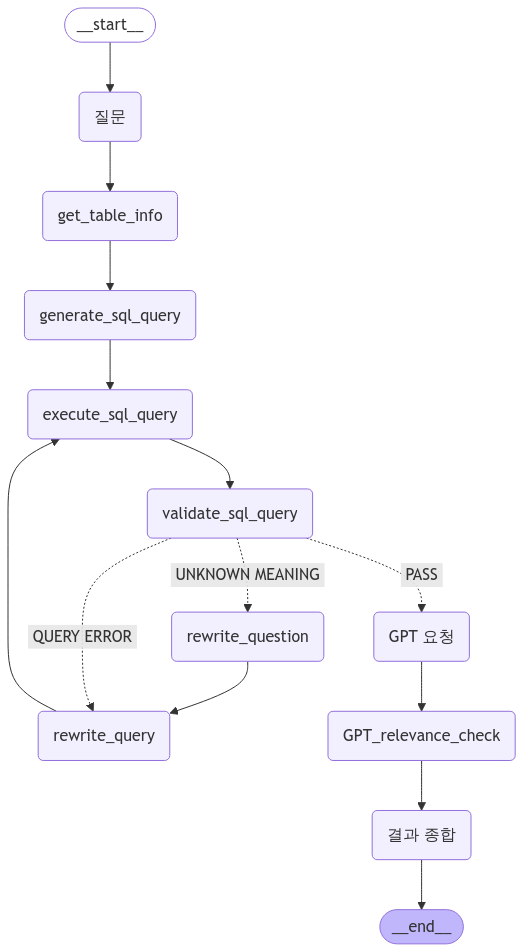

In [17]:
# 그래프 시각화 
img = Image(app.get_graph(xray=True).draw_mermaid_png())

with open("graph_structure.png", "wb") as f:
    f.write(img.data)

display(Image("graph_structure.png"))